### Imports

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

pd.set_option('display.max_columns', 1800)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
mpl.rc('savefig', dpi=200)
params = {'figure.dpi' : 200,
          'figure.figsize' : (12, 10),
          'axes.axisbelow' : True,
          'lines.antialiased' : True,
          'axes.titlesize' : 'xx-large',
          'axes.labelsize' : 'x-large',
          'xtick.labelsize' : 'large',
          'ytick.labelsize' : 'large'}

for (k, v) in params.items():
    plt.rcParams[k] = v

### Data

In [3]:
data = pd.DataFrame()
files = ['data/MERGED2003_PP.csv', 'data/MERGED2005_PP.csv',
         'data/MERGED2007_PP.csv']
dfs = []
for file in files:
    df = pd.read_csv(file, low_memory=False)
    print(df.shape)
    df['type'] = 'training'
    dfs.append(df)

data = pd.concat(dfs)

(6585, 1729)
(6824, 1729)
(6890, 1729)


In [4]:
testing = pd.read_csv('data/MERGED2011_PP.csv', low_memory=False)
print(testing.shape)
testing['type'] = 'testing'

(7675, 1729)


In [5]:
data = pd.concat([data, testing])

In [6]:
data.shape

(27974, 1730)

In [7]:
data.head(3)

,﻿UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,sch_deg,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,region,LOCALE,locale2,LATITUDE,LONGITUDE,CCBASIC,CCUGPROF,CCSIZSET,HBCU,PBI,ANNHI,TRIBAL,AANAPII,HSI,NANTI,MENONLY,WOMENONLY,RELAFFIL,ADM_RATE,ADM_RATE_ALL,SATVR25,SATVR75,SATMT25,SATMT75,SATWR25,SATWR75,SATVRMID,SATMTMID,SATWRMID,ACTCM25,ACTCM75,ACTEN25,ACTEN75,ACTMT25,ACTMT75,ACTWR25,ACTWR75,ACTCMMID,ACTENMID,ACTMTMID,ACTWRMID,SAT_AVG,SAT_AVG_ALL,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,CIP01CERT1,CIP01CERT2,CIP01ASSOC,CIP01CERT4,CIP01BACHL,CIP03CERT1,CIP03CERT2,CIP03ASSOC,CIP03CERT4,CIP03BACHL,CIP04CERT1,CIP04CERT2,CIP04ASSOC,CIP04CERT4,CIP04BACHL,CIP05CERT1,CIP05CERT2,CIP05ASSOC,CIP05CERT4,CIP05BACHL,CIP09CERT1,CIP09CERT2,CIP09ASSOC,CIP09CERT4,CIP09BACHL,CIP10CERT1,CIP10CERT2,CIP10ASSOC,CIP10CERT4,CIP10BACHL,CIP11CERT1,CIP11CERT2,CIP11ASSOC,CIP11CERT4,CIP11BACHL,CIP12CERT1,CIP12CERT2,CIP12ASSOC,CIP12CERT4,CIP12BACHL,CIP13CERT1,CIP13CERT2,CIP13ASSOC,CIP13CERT4,CIP13BACHL,CIP14CERT1,CIP14CERT2,CIP14ASSOC,CIP14CERT4,CIP14BACHL,CIP15CERT1,CIP15CERT2,CIP15ASSOC,CIP15CERT4,CIP15BACHL,CIP16CERT1,CIP16CERT2,CIP16ASSOC,CIP16CERT4,CIP16BACHL,CIP19CERT1,CIP19CERT2,CIP19ASSOC,CIP19CERT4,CIP19BACHL,CIP22CERT1,CIP22CERT2,CIP22ASSOC,CIP22CERT4,CIP22BACHL,CIP23CERT1,CIP23CERT2,CIP23ASSOC,CIP23CERT4,CIP23BACHL,CIP24CERT1,CIP24CERT2,CIP24ASSOC,CIP24CERT4,CIP24BACHL,CIP25CERT1,CIP25CERT2,CIP25ASSOC,CIP25CERT4,CIP25BACHL,CIP26CERT1,CIP26CERT2,CIP26ASSOC,CIP26CERT4,CIP26BACHL,CIP27CERT1,CIP27CERT2,CIP27ASSOC,CIP27CERT4,CIP27BACHL,CIP29CERT1,CIP29CERT2,CIP29ASSOC,CIP29CERT4,CIP29BACHL,CIP30CERT1,CIP30CERT2,CIP30ASSOC,CIP30CERT4,CIP30BACHL,CIP31CERT1,CIP31CERT2,CIP31ASSOC,CIP31CERT4,CIP31BACHL,CIP38CERT1,CIP38CERT2,CIP38ASSOC,CIP38CERT4,CIP38BACHL,CIP39CERT1,CIP39CERT2,CIP39ASSOC,CIP39CERT4,CIP39BACHL,CIP40CERT1,CIP40CERT2,CIP40ASSOC,CIP40CERT4,CIP40BACHL,CIP41CERT1,CIP41CERT2,CIP41ASSOC,CIP41CERT4,CIP41BACHL,CIP42CERT1,CIP42CERT2,CIP42ASSOC,CIP42CERT4,CIP42BACHL,CIP43CERT1,CIP43CERT2,CIP43ASSOC,CIP43CERT4,CIP43BACHL,CIP44CERT1,CIP44CERT2,CIP44ASSOC,CIP44CERT4,CIP44BACHL,CIP45CERT1,CIP45CERT2,CIP45ASSOC,CIP45CERT4,CIP45BACHL,CIP46CERT1,CIP46CERT2,CIP46ASSOC,CIP46CERT4,CIP46BACHL,CIP47CERT1,CIP47CERT2,CIP47ASSOC,CIP47CERT4,CIP47BACHL,CIP48CERT1,CIP48CERT2,CIP48ASSOC,CIP48CERT4,CIP48BACHL,CIP49CERT1,CIP49CERT2,CIP49ASSOC,CIP49CERT4,CIP49BACHL,CIP50CERT1,CIP50CERT2,CIP50ASSOC,CIP50CERT4,CIP50BACHL,CIP51CERT1,CIP51CERT2,CIP51ASSOC,CIP51CERT4,CIP51BACHL,CIP52CERT1,CIP52CERT2,CIP52ASSOC,CIP52CERT4,CIP52BACHL,CIP54CERT1,CIP54CERT2,CIP54ASSOC,CIP54CERT4,CIP54BACHL,DISTANCEONLY,UGDS,UG,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_WHITENH,UGDS_BLACKNH,UGDS_API,UGDS_AIANOld,UGDS_HISPOld,UG_NRA,UG_UNKN,UG_WHITENH,UG_BLACKNH,UG_API,UG_AIANOld,UG_HISPOld,PPTUG_EF,PPTUG_EF2,CURROPER,NPT4_PUB,NPT4_PRIV,NPT4_PROG,NPT4_OTHER,NPT41_PUB,NPT42_PUB,NPT43_PUB,NPT44_PUB,NPT45_PUB,NPT41_PRIV,NPT42_PRIV,NPT43_PRIV,NPT44_PRIV,NPT45_PRIV,NPT41_PROG,NPT42_PROG,NPT43_PROG,NPT44_PROG,NPT45_PROG,NPT41_OTHER,NPT42_OTHER,NPT43_OTHER,NPT44_OTHER,NPT45_OTHER,NPT4_048_PUB,NPT4_048_PRIV,NPT4_048_PROG,NPT4_048_OTHER,NPT4_3075_PUB,NPT4_3075_PRIV,NPT4_75UP_PUB,NPT4_75UP_PRIV,NPT4_3075_PROG,NPT4_3075_OTHER,NPT4_75UP_PROG,NPT4_75UP_OTHER,NUM4_PUB,NUM4_PRIV,NUM4_PROG,NUM4_OTHER,NUM41_PUB,NUM42_PUB,NUM43_PUB,NUM44_PUB,NUM45_PUB,NUM41_PRIV,NUM42_PRIV,NUM43_PRIV,NUM44_PRIV,NUM45_PRIV,NUM41_PROG,NUM42_PROG,NUM43_PROG,NUM44_PROG,NUM45_PROG,NUM41_OTHER,NUM42_OTHER,NUM43_OTHER,NUM44_OTHER,NUM45_OTHER,COSTT4_A,COSTT4_P,TUITIONFEE_IN,TUITIONFEE_OUT,TUITIONFEE_PROG,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,PCTPELL,C150_4,C150_L4,C150_4_POOLED,C150_L4_POOLED,poolyrs,PFTFTUG1_EF,D150_4,D150_L4,D150_4_POOLE

In [8]:
cols_target = ['md_earn_wne_p6']

cols_school = ['PREDDEG', 'HIGHDEG', 'CONTROL', 'NUMBRANCH', 'AVGFACSAL']
#                'PCIP01', 'PCIP03', 'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10',
#                'PCIP11', 'PCIP12', 'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16',
#                'PCIP19', 'PCIP22', 'PCIP23', 'PCIP24', 'PCIP25', 'PCIP26',
#                'PCIP27', 'PCIP29', 'PCIP30', 'PCIP31', 'PCIP38', 'PCIP39',
#                'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43', 'PCIP44', 'PCIP45',
#                'PCIP46', 'PCIP47', 'PCIP48', 'PCIP49', 'PCIP50', 'PCIP51',
#                'PCIP52', 'PCIP54']

# cols_admissions = ['ADM_RATE', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'SAT_AVG']

cols_costs = ['TUITFTE']

cols_studentbody = ['UGDS', 'UGDS_NRA', 'PPTUG_EF', 'UG25abv',
                    'PAR_ED_PCT_1STGEN', 'DEP_INC_AVG', 'IND_INC_AVG',
                    'COMP_ORIG_YR2_RT', 'WDRAW_ORIG_YR2_RT', 'ENRL_ORIG_YR2_RT',
                    'COMP_ORIG_YR4_RT', 'WDRAW_ORIG_YR4_RT', 'ENRL_ORIG_YR4_RT',
                    'OVERALL_YR2_N', 'OVERALL_YR3_N', 'OVERALL_YR4_N',
                    'OVERALL_YR6_N', 'OVERALL_YR8_N', 'count_nwne_p6']

cols_financialaid = ['DEBT_MDN', 'GRAD_DEBT_MDN', 'WDRAW_DEBT_MDN']

cols_other = ['type']

In [9]:
data.shape

(27974, 1730)

In [10]:
data_reduced = data[cols_target+cols_school+cols_costs+\
                    cols_studentbody+cols_financialaid+cols_other]

In [11]:
for c in data_reduced.columns:
    if (data_reduced[c].dtype == object) and (c != 'type'):
        data_reduced[c] = data_reduced[c].apply(lambda x: float(x) if x != 'PrivacySuppressed' else np.nan)
        data_reduced[c] = data_reduced[c].astype(float)

In [12]:
data_reduced.describe()

,md_earn_wne_p6,PREDDEG,HIGHDEG,CONTROL,NUMBRANCH,AVGFACSAL,TUITFTE,UGDS,UGDS_NRA,PPTUG_EF,UG25abv,PAR_ED_PCT_1STGEN,DEP_INC_AVG,IND_INC_AVG,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,ENRL_ORIG_YR2_RT,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,OVERALL_YR2_N,OVERALL_YR3_N,OVERALL_YR4_N,OVERALL_YR6_N,OVERALL_YR8_N,count_nwne_p6,DEBT_MDN,GRAD_DEBT_MDN,WDRAW_DEBT_MDN
count,22394.000000,27974.000000,27974.000000,27974.000000,27974.000000,17094.000000,26958.000000,26084.000000,26084.000000,25961.000000,25830.000000,24461.000000,25166.000000,25303.000000,22303.000000,22473.000000,20116.000000,22184.000000,21849.000000,19316.000000,26230.000000,25815.000000,25535.000000,24948.000000,18614.000000,24423.000000,22847.000000,21627.000000,21315.000000
mean,29062.007681,1.857582,2.213877,2.118932,4.037070,5348.674798,11011.289970,2222.314944,0.014165,0.223849,0.413015,0.493549,52556.296987,22942.376603,0.278013,0.205554,0.238424,0.374718,0.205404,0.040188,2614.042242,2266.867209,1965.423497,1385.139370,1334.820297,249.651435,8994.602180,12483.039742,6405.177668
std,10822.399280,1.008607,1.274660,0.841436,12.977136,1935.658093,172001.637782,4855.392337,0.043849,0.240339,0.220127,0.135478,24402.757134,9926.116828,0.254066,0.135533,0.195519,0.243561,0.144668,0.050813,14366.819640,13225.712340,10592.497586,5225.296605,5179.278829,891.605076,4821.270423,7030.661573,3447.324241
min,7000.000000,0.000000,0.000000,1.000000,1.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000400,0.000000,443.174960,215.042694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,124.000000,654.000000,520.000000
25%,22000.000000,1.000000,1.000000,1.000000,1.000000,4088.250000,2537.750000,127.000000,0.000000,0.000000,0.253025,0.413534,33732.107442,16257.267275,0.062918,0.106195,0.060261,0.155203,0.101010,0.000000,119.000000,116.000000,114.000000,107.000000,111.000000,23.000000,5400.000000,6625.000000,3750.000000
50%,27500.000000,2.000000,2.000000,2.000000,1.000000,5160.000000,5909.000000,522.000000,0.000000,0.145700,0.411000,0.510294,49126.867425,21397.270020,0.160684,0.198300,0.204279,0.378328,0.195652,0.025147,450.000000,420.000000,407.000000,373.000000,369.000000,66.000000,7905.000000,11119.000000,5500.000000
75%,34400.000000,3.000000,4.000000,3.000000,2.000000,6376.000000,10877.750000,2067.000000,0.011200,0.386400,0.563400,0.581560,68785.735878,27541.043335,0.514689,0.293532,0.391884,0.571936,0.295954,0.066380,1350.000000,1230.000000,1139.500000,994.000000,968.000000,186.000000,12000.000000,17125.000000,8250.000000
max,133600.000000,4.000000,4.000000,3.000000,128.000000,24699.000000,26670163.000000,249604.000000,1.000000,1.000000,1.000000,1.000000,181008.007100,79375.209910,1.000000,0.781513,1.000000,1.000000,0.842161,0.694737,237888.000000,222715.000000,170316.000000,72057.000000,70824.000000,12567.000000,95984.000000,47186.500000,33125.000000


In [13]:
data_reduced.dropna(inplace=True)

In [14]:
data_reduced.shape

(6717, 30)

In [15]:
6809 / 27974

0.24340458997640665

In [16]:
data_reduced.type.value_counts()

training    4173
testing     2544
dtype: int64

In [17]:
training = data_reduced[data_reduced['type'] == 'training']
testing = data_reduced[data_reduced['type'] == 'testing']

In [18]:
training.md_earn_wne_p6.values

array([ 25700.,  35100.,  40600., ...,  36500.,  36500.,  36500.])

In [19]:
X_train = normalize(training.iloc[:, 1:-1].values)
y_train = training.md_earn_wne_p6.values

In [20]:
X_test = normalize(testing.iloc[:, 1:-1].values)
y_test = testing.md_earn_wne_p6.values

In [21]:
names = data_reduced.columns[1:-1]

In [22]:
len(names)

28

### Random Forest

In [23]:
rf = RandomForestRegressor(random_state=1868)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1868,
           verbose=0, warm_start=False)

In [24]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 2), rf.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.20999999999999999, 'count_nwne_p6'), (0.19, 'NUMBRANCH'), (0.10000000000000001, 'CONTROL'), (0.089999999999999997, 'PAR_ED_PCT_1STGEN'), (0.059999999999999998, 'PREDDEG'), (0.040000000000000001, 'GRAD_DEBT_MDN'), (0.040000000000000001, 'AVGFACSAL'), (0.029999999999999999, 'WDRAW_ORIG_YR4_RT'), (0.02, 'WDRAW_ORIG_YR2_RT'), (0.02, 'TUITFTE'), (0.02, 'IND_INC_AVG'), (0.02, 'DEP_INC_AVG'), (0.02, 'DEBT_MDN'), (0.02, 'COMP_ORIG_YR4_RT'), (0.01, 'WDRAW_DEBT_MDN'), (0.01, 'UGDS'), (0.01, 'UG25abv'), (0.01, 'PPTUG_EF'), (0.01, 'OVERALL_YR8_N'), (0.01, 'OVERALL_YR6_N'), (0.01, 'OVERALL_YR3_N'), (0.01, 'OVERALL_YR2_N'), (0.01, 'HIGHDEG'), (0.01, 'ENRL_ORIG_YR4_RT'), (0.01, 'ENRL_ORIG_YR2_RT'), (0.01, 'COMP_ORIG_YR2_RT'), (0.0, 'UGDS_NRA'), (0.0, 'OVERALL_YR4_N')]


In [25]:
yhat = rf.predict(X_test)

In [26]:
mean_squared_error(y_test, yhat)**0.5

8085.3402528722918

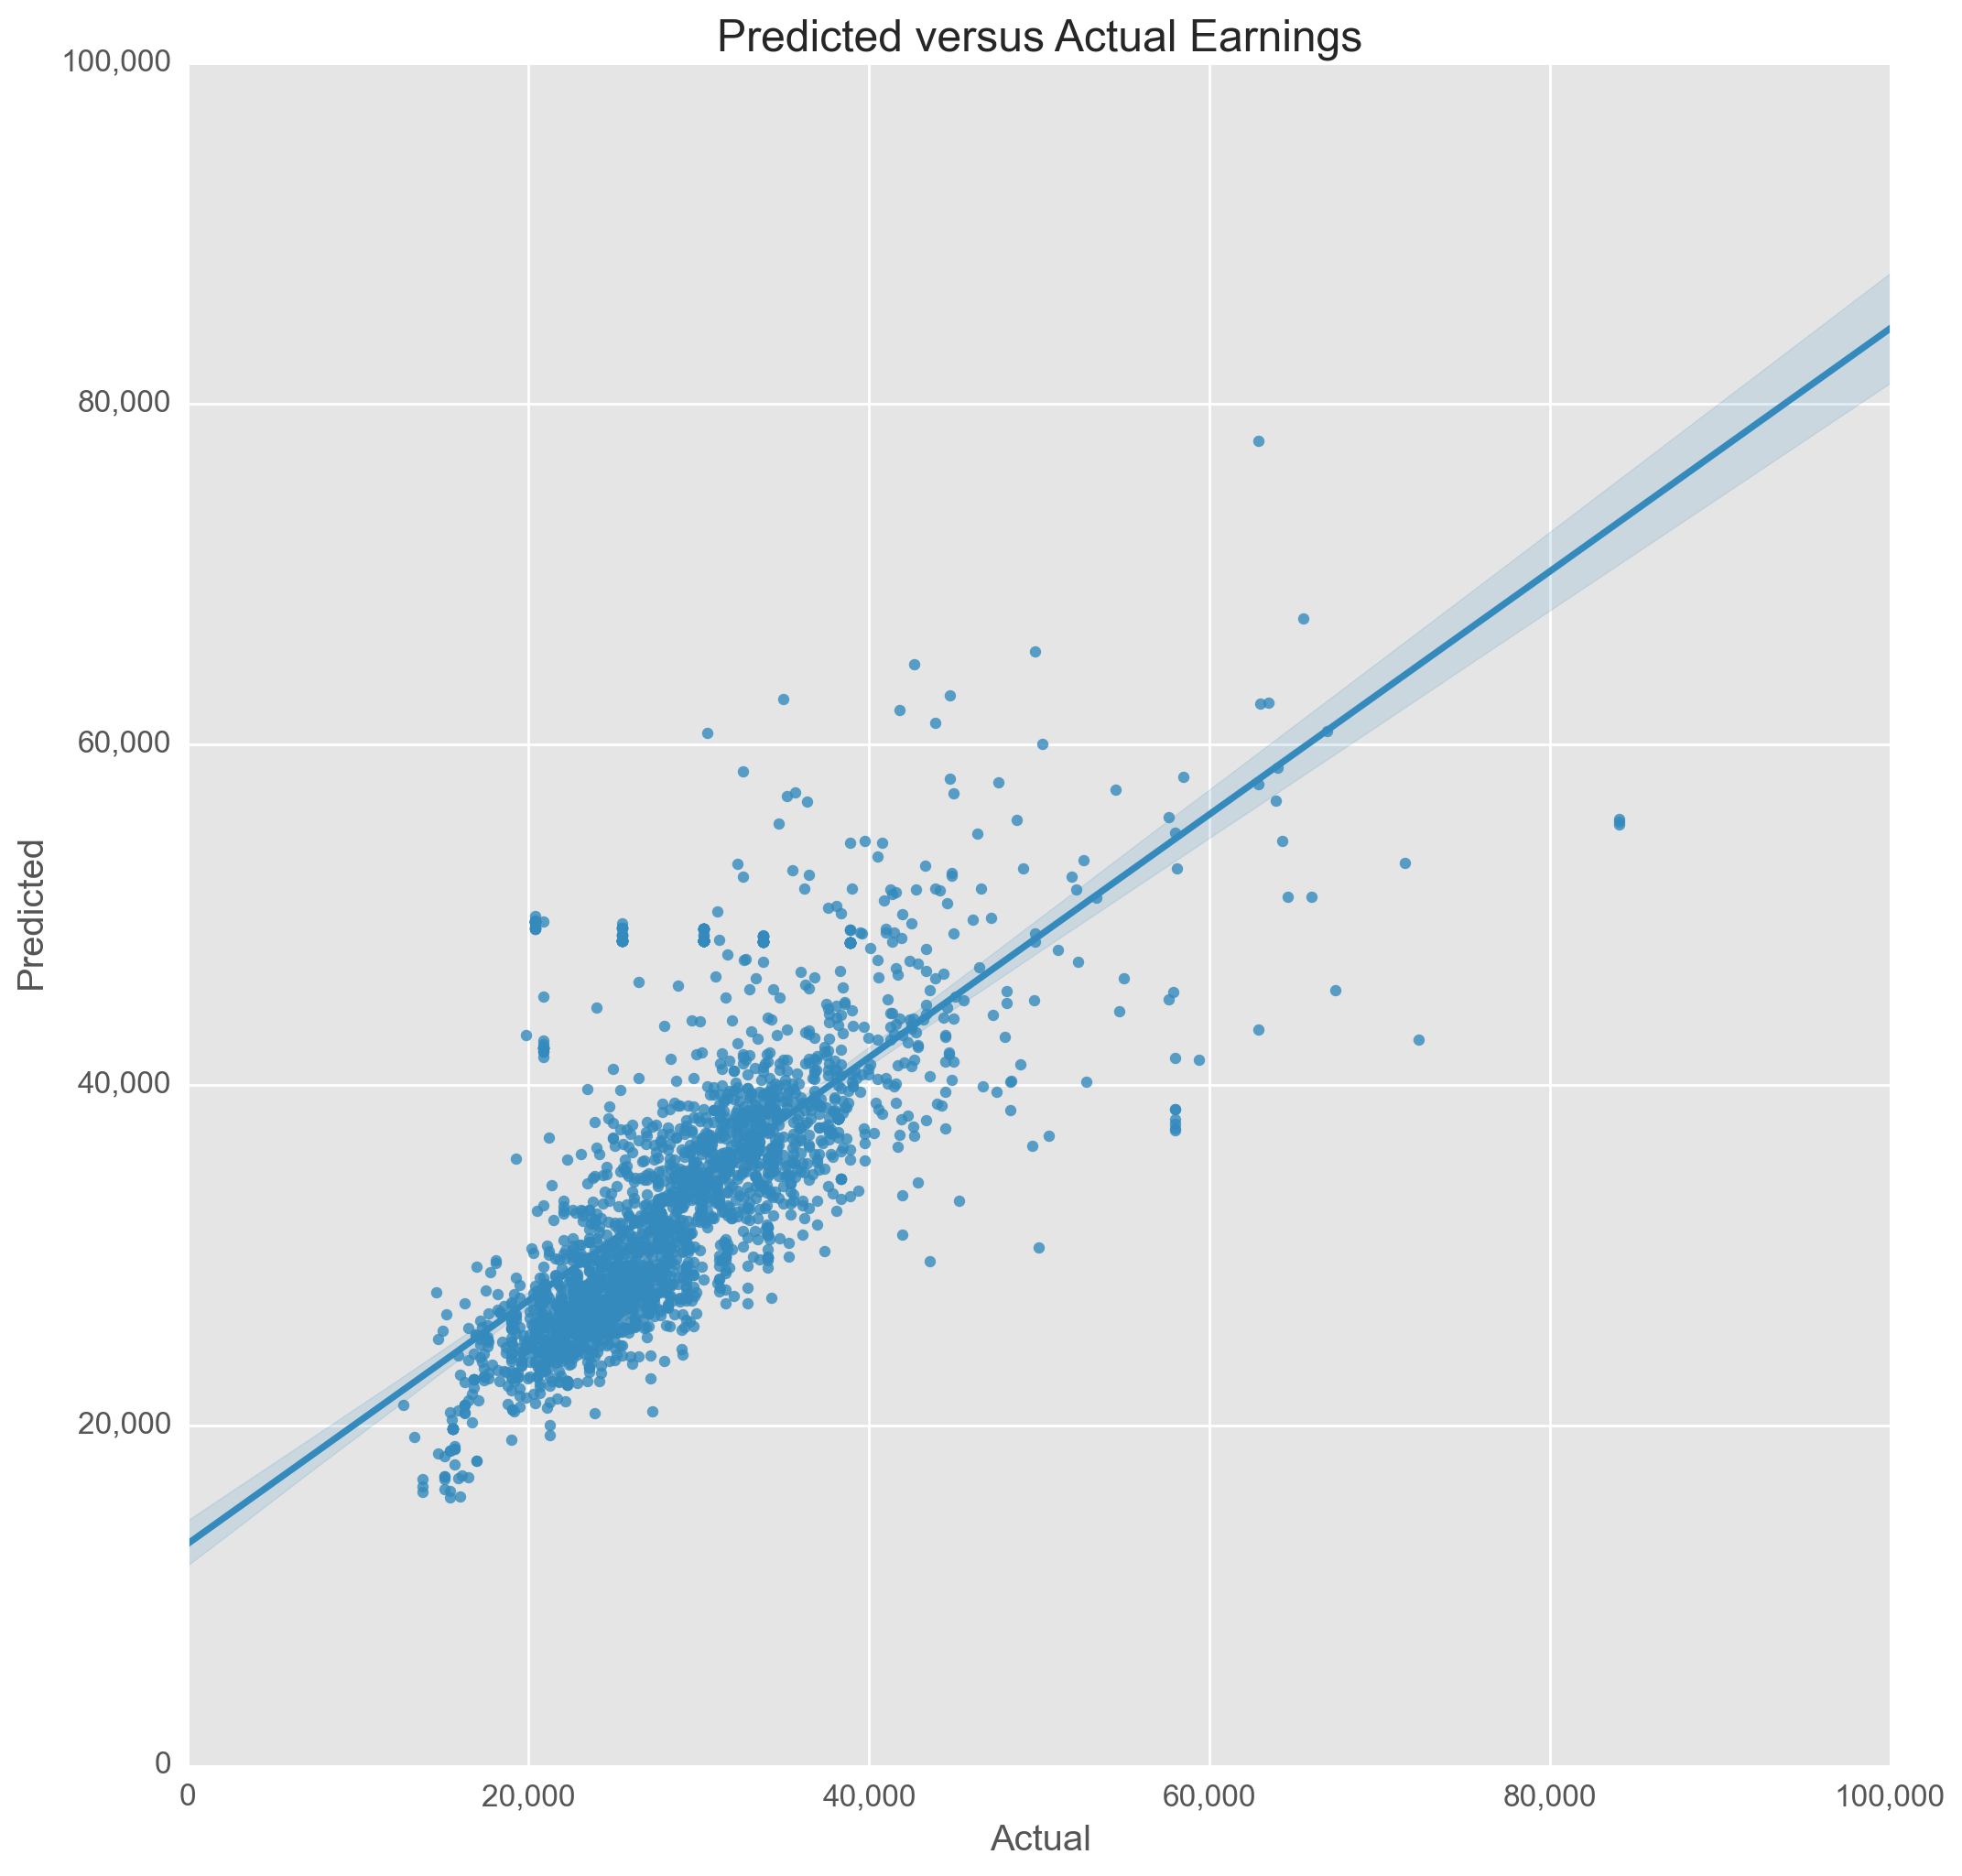

In [27]:
plt.figure(figsize=(12, 12))

sns.regplot(x=y_test, y=yhat, color='#348ABD');

plt.title('Predicted versus Actual Earnings')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(0, 100000);
plt.ylim(0, 100000);

plt.gca().get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)

### Multiple Regression

In [28]:
features_use = ['count_nwne_p6', 'NUMBRANCH', 'CONTROL', 'PAR_ED_PCT_1STGEN',
                'PREDDEG', 'GRAD_DEBT_MDN', 'AVGFACSAL', 'WDRAW_ORIG_YR4_RT',
                'WDRAW_ORIG_YR2_RT', 'TUITFTE', 'IND_INC_AVG', 'DEP_INC_AVG',
                'DEBT_MDN', 'COMP_ORIG_YR4_RT']

In [29]:
data_reduced = data[cols_target+features_use+cols_other]

for c in data_reduced.columns:
    if (data_reduced[c].dtype == object) and (c != 'type'):
        data_reduced[c] = data_reduced[c].apply(lambda x: float(x) if x != 'PrivacySuppressed' else np.nan)
        data_reduced[c] = data_reduced[c].astype(float)

data_reduced.dropna(inplace=True)

training = data_reduced[data_reduced['type'] == 'training']
testing = data_reduced[data_reduced['type'] == 'testing']

X_train = scale(training.iloc[:, 1:-1].values)
y_train = training.md_earn_wne_p6.values

X_test = scale(testing.iloc[:, 1:-1].values)
y_test = testing.md_earn_wne_p6.values

#### OLS

In [30]:
ols = LinearRegression()

In [31]:
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
yhat = ols.predict(X_test)

In [33]:
mean_squared_error(y_test, yhat)**0.5

7162.4807037804103

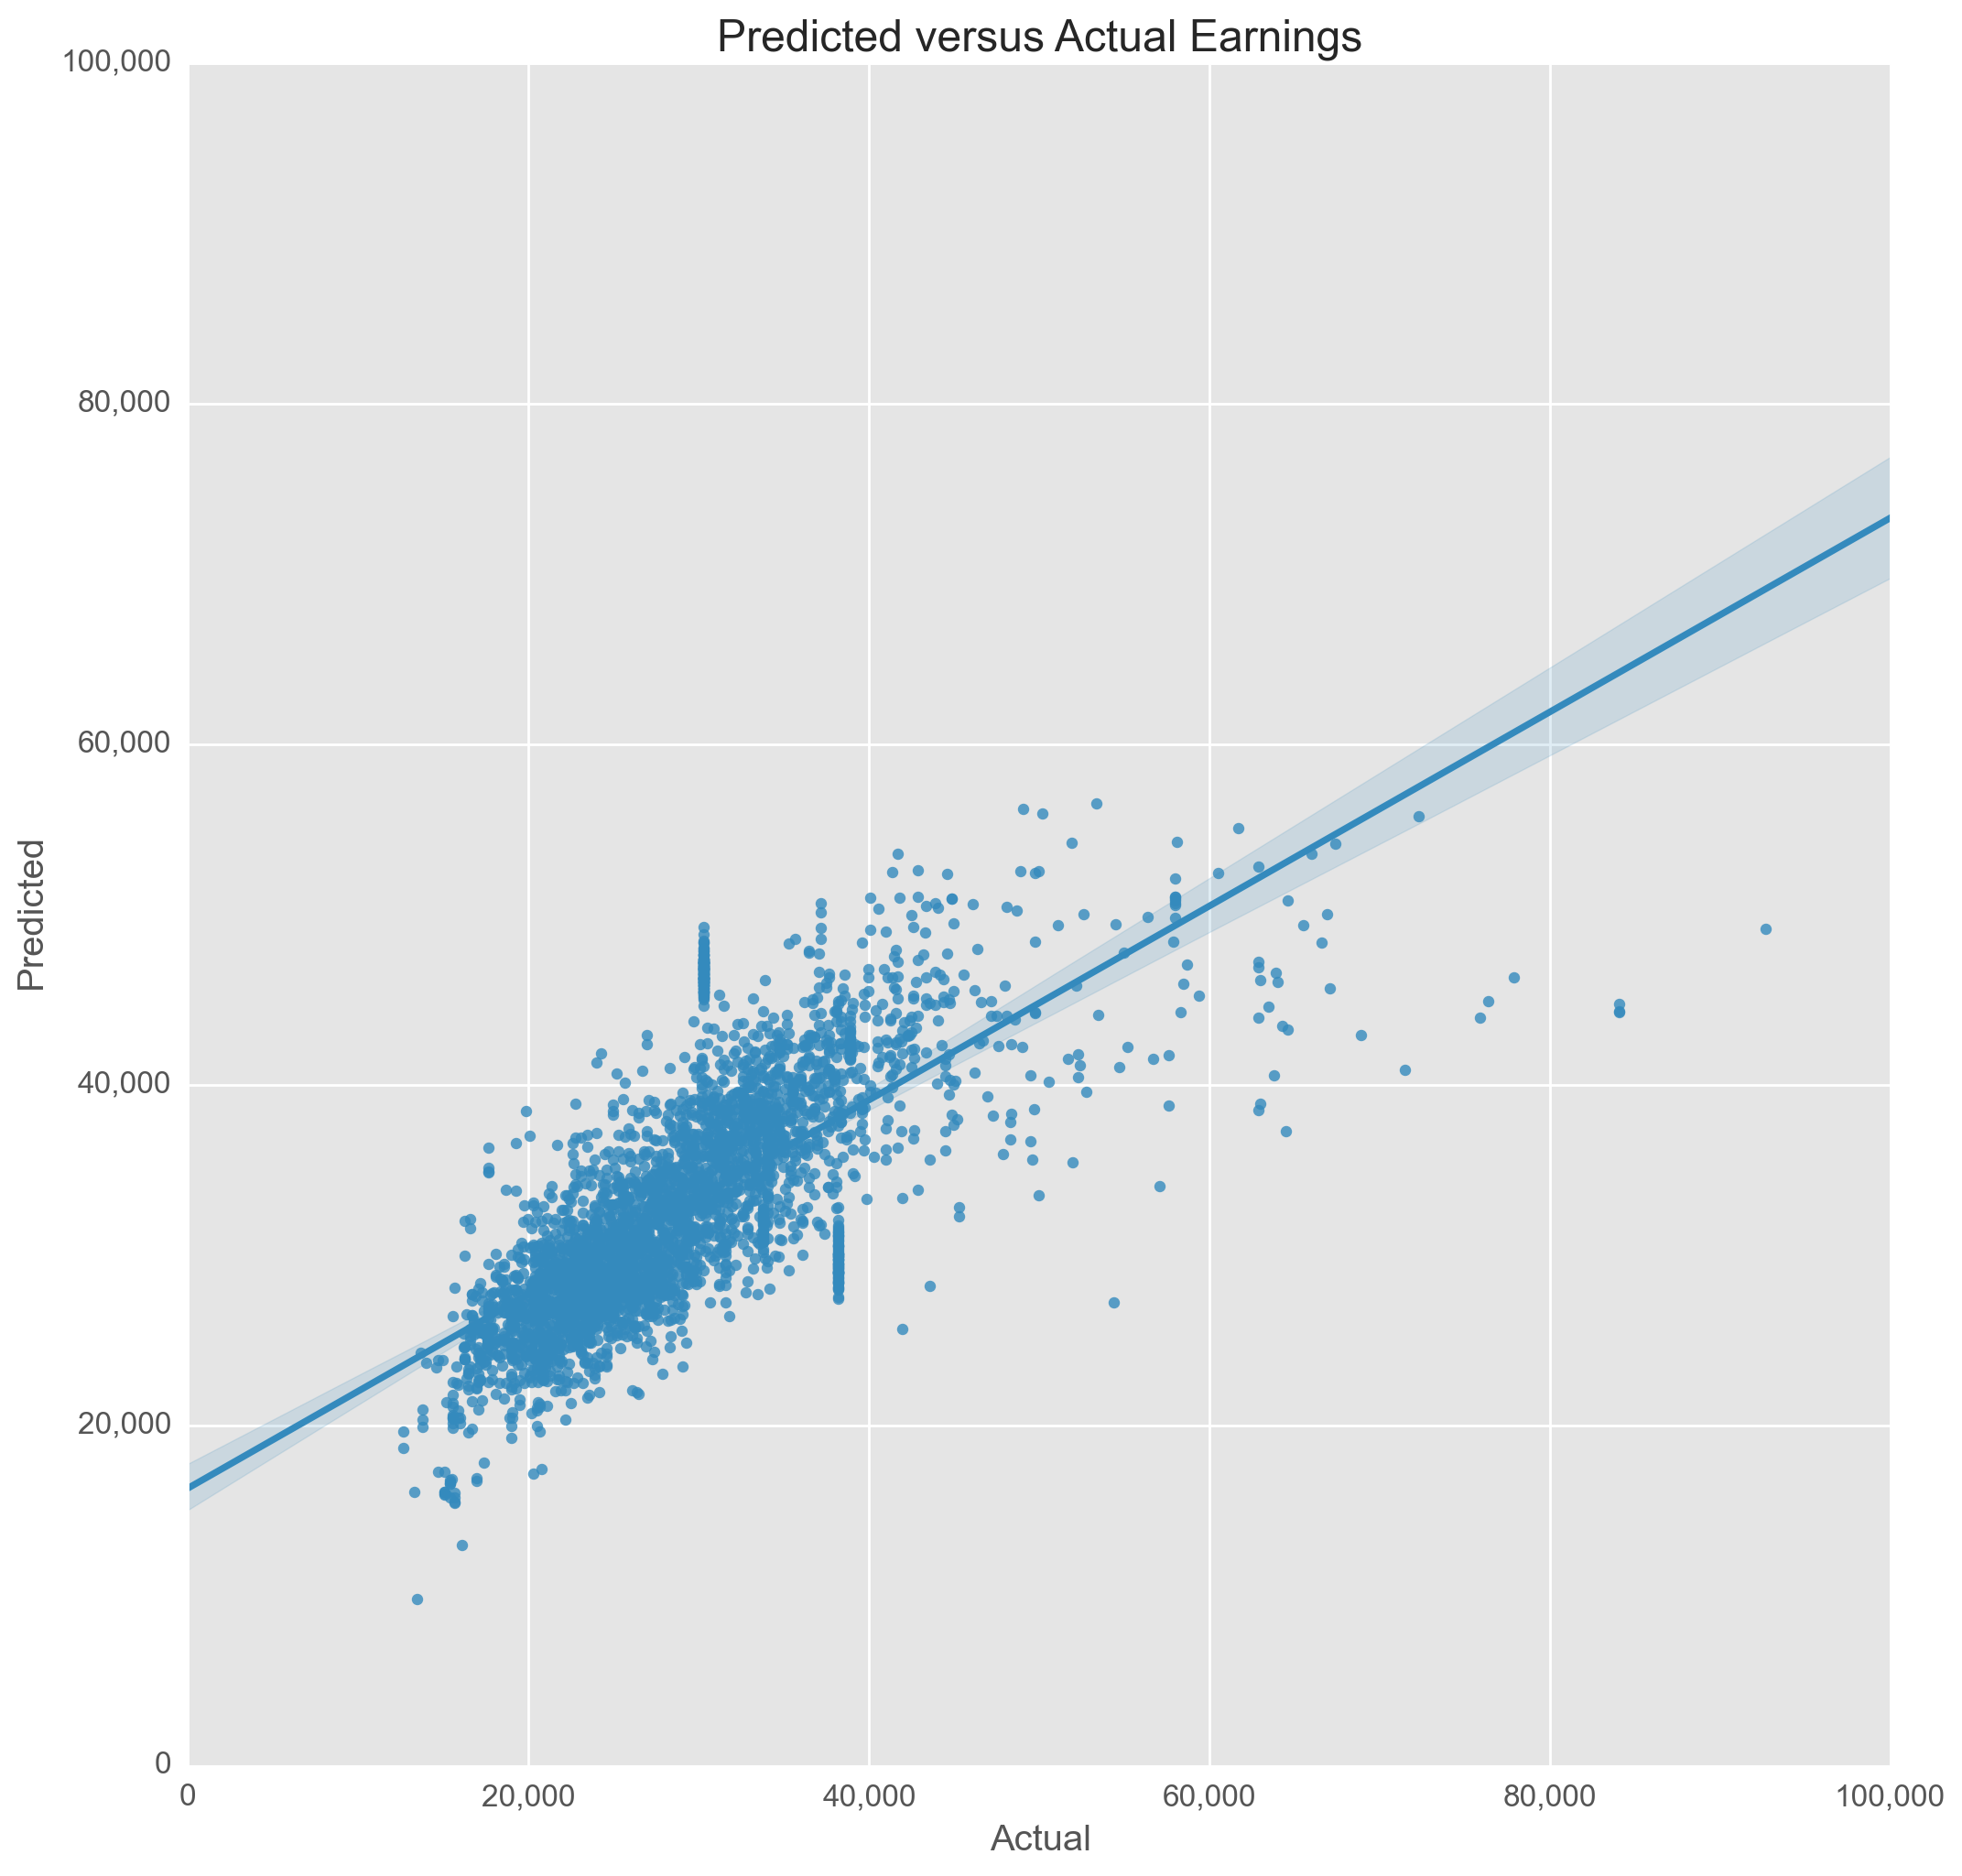

In [34]:
plt.figure(figsize=(12, 12))

sns.regplot(x=y_test, y=yhat, color='#348ABD');

plt.title('Predicted versus Actual Earnings')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(0, 100000);
plt.ylim(0, 100000);

plt.gca().get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)

#### Random Forest

In [35]:
rf = RandomForestRegressor(random_state=1868)
rf.fit(X_train, y_train)

yhat = rf.predict(X_test)
mean_squared_error(y_test, yhat)**0.5

6754.289052133895

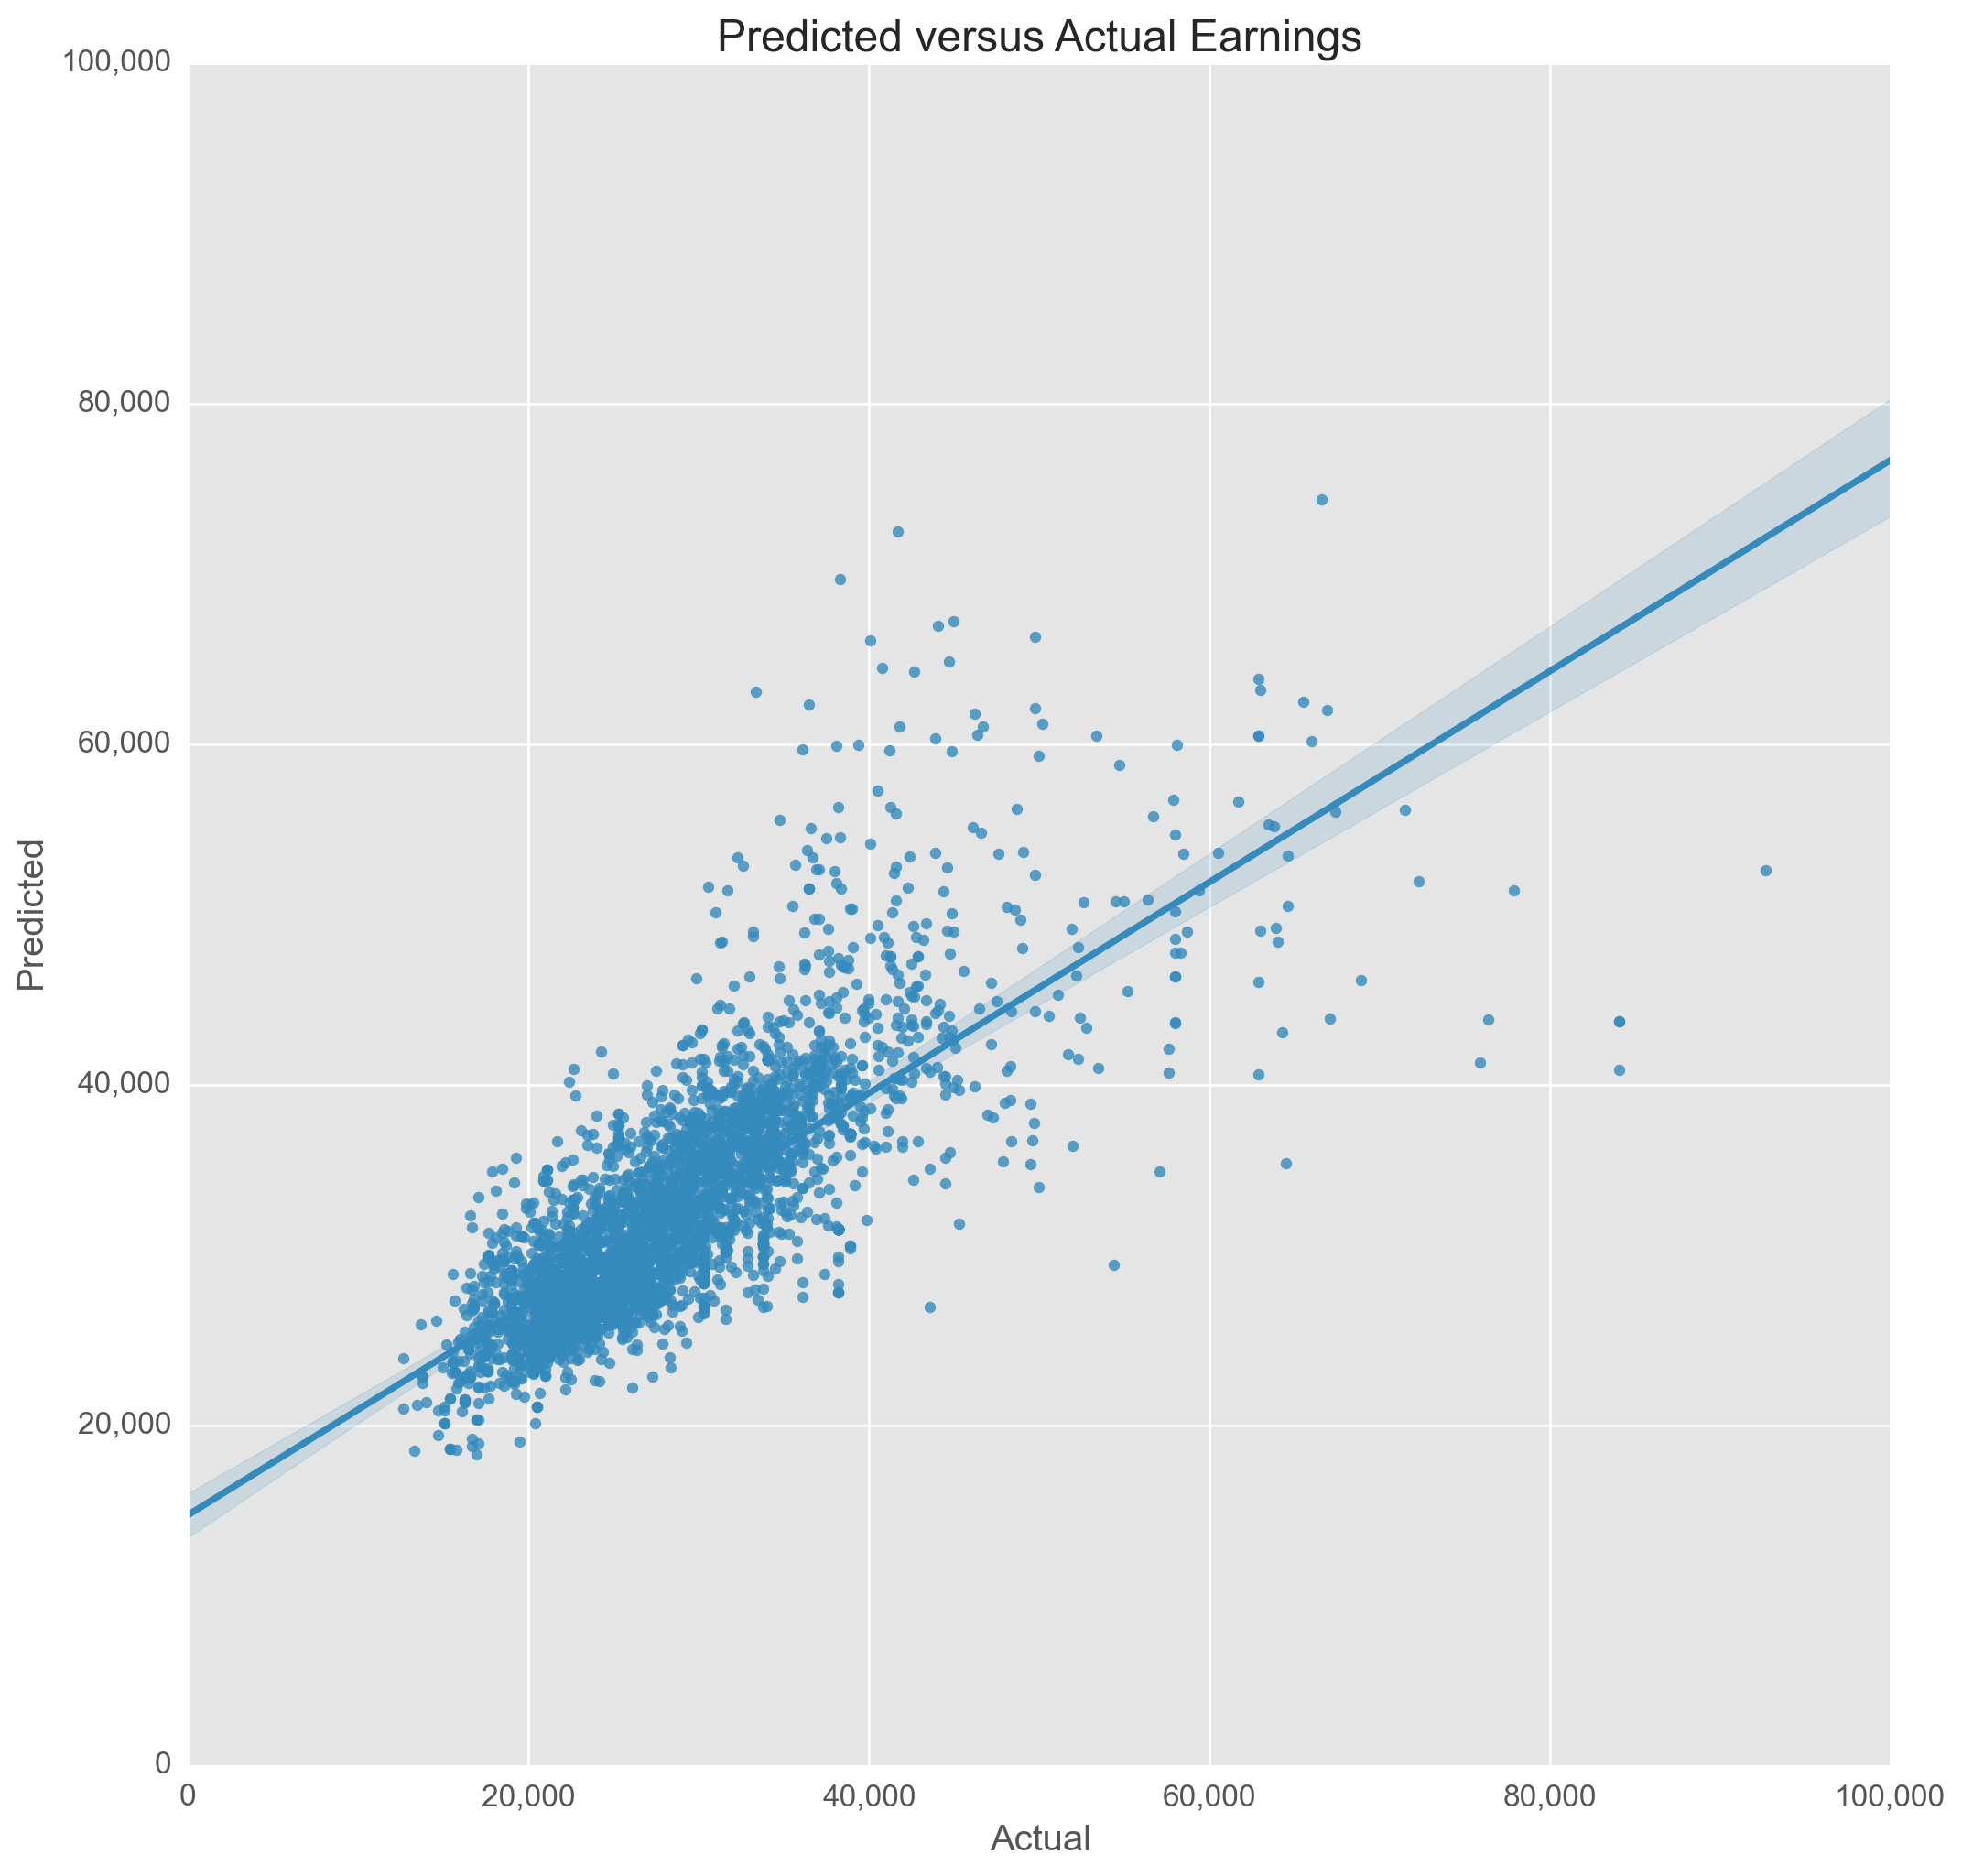

In [36]:
plt.figure(figsize=(12, 12))

sns.regplot(x=y_test, y=yhat, color='#348ABD');

plt.title('Predicted versus Actual Earnings')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(0, 100000);
plt.ylim(0, 100000);

plt.gca().get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)